In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')

def load_cifar():
    from tensorflow.keras.datasets import cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return (x_train, y_train), (x_test, y_test)
    
(x_train, y_train), (x_test, y_test) = load_cifar()


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [2]:
from cifar.cifar_capsnet_bnorm import CapsNetCifar

ROUTINGS = 3
BATCH_SIZE = 100
INPUT_SHAPE = (32, 32, 3)
N_CLASS = 10

model, eval_model, manipulate_model = CapsNetCifar(input_shape=INPUT_SHAPE,
                                                   n_class=N_CLASS,
                                                   routings=ROUTINGS,
                                                   batch_size=BATCH_SIZE)
model.summary()


starting CapsNetCifar (32, 32, 3) 10 3 100
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(100, 32, 32, 3)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (100, 24, 24, 64)    15616       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (100, 24, 24, 64)    256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (100, 18, 18, 128)   401536      batch_normalization[0][0]        
___________________________________________________

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    mean = tf.reduce_mean(tf.reduce_sum(L, 1))
    return mean


lr = 0.001
lam_recon = 0.392
# compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                loss=[margin_loss, 'mse'],
                loss_weights=[1., lam_recon],
                metrics={'capsnet': 'accuracy'})
# tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)


In [5]:
from utils.utils import combine_images, plot_log
from metrics import get_callbacks
run_fit = True
save_dir='./result/capsnet_cifar/capsnet_cifar_modif-bnorm'
weights = save_dir + '/trained_model.h5'

def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        for next_generated in generator:
            yield (next_generated[0], next_generated[1]), (next_generated[1], next_generated[0])

net_callbacks = get_callbacks(save_dir, lr)
if(run_fit):
    model.fit(train_generator(x_train, y_train, BATCH_SIZE),
                steps_per_epoch=int(y_train.shape[0] / BATCH_SIZE),
                epochs=20,
                validation_data=((x_test, y_test), (y_test, x_test)),
                batch_size=BATCH_SIZE,
                callbacks=[net_callbacks])
    model.save_weights(save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % save_dir)
else:
    model.load_weights(weights)

# plot_log(save_dir + '/log.csv', show=True)

Epoch 1/20
500/500 [==============================] - 218s 435ms/step - loss: 0.4482 - capsnet_loss: 0.4292 - decoder_loss: 0.0487 - capsnet_accuracy: 0.3382 - val_loss: 0.4765 - val_capsnet_loss: 0.4559 - val_decoder_loss: 0.0525 - val_capsnet_accuracy: 0.3078

Epoch 00001: val_capsnet_accuracy improved from -inf to 0.30780, saving model to ./result/capsnet_cifar/capsnet_cifar_modif-bnorm\weights-01.h5
Epoch 2/20
500/500 [==============================] - 174s 348ms/step - loss: 0.3496 - capsnet_loss: 0.3342 - decoder_loss: 0.0392 - capsnet_accuracy: 0.5067 - val_loss: 0.3407 - val_capsnet_loss: 0.3253 - val_decoder_loss: 0.0392 - val_capsnet_accuracy: 0.5179

Epoch 00002: val_capsnet_accuracy improved from 0.30780 to 0.51790, saving model to ./result/capsnet_cifar/capsnet_cifar_modif-bnorm\weights-02.h5
Epoch 3/20
500/500 [==============================] - 172s 344ms/step - loss: 0.2994 - capsnet_loss: 0.2850 - decoder_loss: 0.0367 - capsnet_accuracy: 0.5874 - val_loss: 0.3324 - val_

(9, 9, 3, 64) (64,)
-0.23205729 0.2995962
0.0 1.0


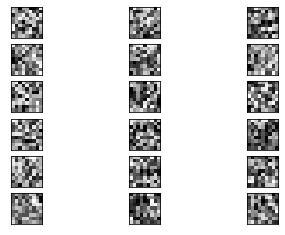

In [6]:
import matplotlib.pyplot as plt

conv_layer = model.layers[1]
filters, biases = conv_layer.get_weights()
print(filters.shape, biases.shape)
def print_filter(filters):
	f_min, f_max = filters.min(), filters.max()
	print(f_min, f_max)
	filters = (filters - f_min) / (f_max - f_min)
	f_min, f_max = filters.min(), filters.max()
	print(f_min, f_max)

	n_filters, ix = 6, 1
	for i in range(n_filters):
		# get the filter
		f = filters[:, :, :, i]
		
		# plot each channel separately
		for j in range(3):
			# specify subplot and turn of axis
			ax = plt.subplot(n_filters, 3, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(f[:, :, j], cmap='gray')
			ix += 1
	# show the figure
	plt.show()
print_filter(filters)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000022D31C38430>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022D60EBD520>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000022D60EBDB50>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022D60FF74F0>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000022D61011640>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022D6107DD60>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000022D61085DC0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022D6107FF70>, <tensorflow.python.keras.layers.core.Reshape object at 0x0000022D6107F220>, <tensorflow.python.keras.layers.core.Lambda object at 0x0000022D610A0F70>, <capsnet.capsule_layers.CapsuleLayer object at 0x0000022D61104EB0>, <tensorflow.python.keras.engine.input_layer.InputLayer object

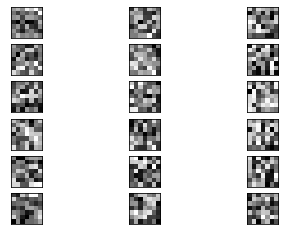

In [7]:
print(model.layers)
conv_layer = model.layers[3]
filters, biases = conv_layer.get_weights()
filters.shape
print_filter(filters)

c:\Users\Tautvydas\Documents\magistras\master_capsnet\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0-rc2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


------------------------------Begin: test------------------------------
Reconstructed images are saved to ./result/capsnet_cifar/capsnet_cifar_modif-bnorm/images_eval.png
------------------------------End: test------------------------------


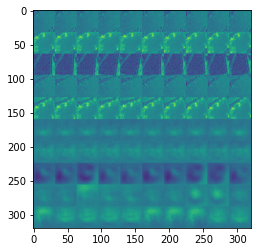

------------------------------Begin: test------------------------------
Reconstructed images are saved to ./result/capsnet_cifar/capsnet_cifar_modif-bnorm/x_test.png
------------------------------End: test------------------------------


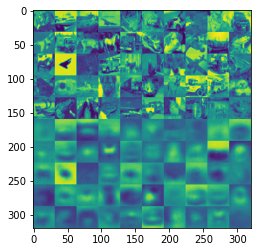

In [8]:
from images import get_images_eval, predict_and_print, create_batch, images_train, images_valid, images_test, preprocess_image_with_angle

images_eval = get_images_eval()

predict_and_print(save_dir, eval_model, images_eval, "images_eval")
predict_and_print(save_dir, eval_model, x_test, "x_test")
